<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/causalml/ihdp_meta_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install causalml

     |████████████████████████████████| 3.9MB 2.7MB/s 
     |████████████████████████████████| 276kB 29.5MB/s 
     |████████████████████████████████| 1.8MB 27.4MB/s 
  Created wheel for causalml: filename=causalml-0.8.0-cp36-cp36m-linux_x86_64.whl size=482060 sha256=bf1fec4f1f54f11f4dc10f79d0e94fef2b80f75e86e4eb89f19032584de71085
  Stored in directory: /root/.cache/pip/wheels/db/d8/1f/c5c57e0a0a1e2d597da3b4b73f26a0365874e363bb1b57db41
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394131 sha256=d2e5d1dc5e29cbe8c95329090456d932cf6071efbede34c307a44e5e0cceb811
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
%cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/causalML
%ls

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/causalML
prac_meta_learners.ipynb  uplift_result20200425_150924.png
prac_uplift.ipynb         uplift_result20200426_043322.png


# Causalmlの練習

In [68]:
import os

import numpy as np
import pandas as pd

from causalml.inference.meta import BaseXRegressor
from causalml.propensity import ElasticNetPropensityModel
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

## IHDPデータセット読み込み
IHDP:The Infant Health and Development Programデータセットについて：[https://www.jpeds.com/article/S0022-3476(14)00931-7/pdf](https://www.jpeds.com/article/S0022-3476(14)00931-7/pdf)

In [168]:
csv_path = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
df= pd.read_csv(csv_path, header = None)

col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"]
feature_cols = []
for i in range(1,26):
    feature_cols.append("x"+str(i))

col.extend(feature_cols)
df.columns = col
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0


In [11]:
df.describe()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
count,747.000000,747.000000,747.000000,747.000000,747.000000,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,0.186078,3.159538,5.696107,2.432513,6.448580,1.716610e-17,-6.911027e-17,5.900382e-17,-9.143363e-16,-3.165696e-17,-7.874855e-16,0.514056,0.093708,0.520750,0.364123,0.269076,0.219545,0.358768,1.463186,0.140562,0.959839,0.594378,0.963855,0.135207,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965
std,0.389430,2.179956,1.980121,1.281515,0.454766,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500137,0.291618,0.499904,0.481506,0.443777,0.414216,0.479960,0.498977,0.347802,0.196467,0.491341,0.186775,0.342174,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953
min,0.000000,-1.543902,-1.037628,0.924453,5.591647,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.626779,5.053598,1.518409,6.087863,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.577294,6.209686,2.114661,6.419095,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.494637,6.948922,2.989305,6.765241,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,11.268228,10.171004,9.821792,7.954804,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 真の因果効果
実際には求められない値<br>

In [125]:
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
tau.mean()

4.0296612252168975

### 単純な平均値の比較

In [114]:
control_group = df.query('treatment==0')['y_factual'].mean()
treatment_group = df.query('treatment==1')['y_factual'].mean()
print('介入群のアウトカムの平均値:{}'.format(control_group))
print('コントロール群のアウトカムの平均値:{}'.format(treatment_group))
print('単純な平均値の差:{}'.format(treatment_group-control_group))

介入群のアウトカムの平均値:2.4112967999916193
コントロール群のアウトカムの平均値:6.432417812422451
単純な平均値の差:4.021121012430832


今回求めた推定量を$\hat{\tau}_{naive}$と置くと
$$\hat{\tau}_{naive} = E[Y^{(1)}|t=1]-E[Y^{(0)}|t=0]$$
$$=E[Y^{(1)}-Y^{(0)}]+E[Y^{(0)}|t=1]-E[Y^{(0)}|t=0]$$
セレクションバイアスが生じているため、**単純な平均値の差の比較**では望ましくない因果効果の算出方法であることが分かる。<br>
<font color="Red">（今回のデータセットについては、実験方法がRCTであるため、単純な平均値の差を求めてもセレクションバイアスがあまり生じず、真の因果効果に近くなっている）</font>

In [37]:
OUTCOME_COLUMN = 'y_factual'
TREATMENT_COLUMN = 'treatment'
UNNECESSARY_COLUMNS = ["y_cfactual", "mu0", "mu1"]
data = df.drop(columns=UNNECESSARY_COLUMNS).copy()

SEED = 2
train_X, test_X, train_y, test_y = train_test_split(data.drop(columns=OUTCOME_COLUMN).values, data[OUTCOME_COLUMN].values,
                                                    test_size=0.2, random_state=SEED)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=0.2, random_state=SEED)
# t:treatment(介入変数)の取り出し
train_t = train_X[:,0].astype(int)
train_X = train_X[:,1:]
val_t = val_X[:,0].astype(int)
val_X = val_X[:,1:]
test_t = test_X[:,0].astype(int)
test_X = test_X[:,1:]

print('data.shape:{}'.format(data.shape))
print('train_X:{}, train_t:{}, train_y:{}'.format(train_X.shape, train_t.shape, train_y.shape))
print('val_X:{}, val_t:{}, val_y:{}'.format(val_X.shape, val_t.shape, val_y.shape))
print(('test_X:{}, test_t:{}, test_y:{}'.format(test_X.shape, test_t.shape, test_y.shape)))

data.shape:(747, 27)
train_X:(477, 25), train_t:(477,), train_y:(477,)
val_X:(120, 25), val_t:(120,), val_y:(120,)
test_X:(150, 25), test_t:(150,), test_y:(150,)


## 傾向スコアモデル作成

In [76]:
# causalmlで使用できるElasticNetPropensityModelでは内部でsklearn.linear_model.ElasticNetCVが使われている
# ElasticNetPropensityModelでは検証用データを使えなさそうなので、過学習を防ぐためにも今回はxgboostを使用
# ps：propensity score(傾向スコア)
ps_model = XGBClassifier(random_state=SEED)
# 目的変数をTreatmentとして学習
ps_model.fit(X=train_X, y=train_t, eval_set=[(val_X, val_t)],
             early_stopping_rounds=5)

# 傾向スコア算出
train_ps = ps_model.predict_proba(data=train_X)[:,1]
val_ps = ps_model.predict_proba(data=val_X)[:,1]
print('train_ps:{}, val_ps:{}'.format(train_ps.shape, val_ps.shape))
print('train_ps[:5]:{}'.format(train_ps[:5]))

[0]	validation_0-error:0.158333
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.158333
[2]	validation_0-error:0.15
[3]	validation_0-error:0.15
[4]	validation_0-error:0.15
[5]	validation_0-error:0.15
[6]	validation_0-error:0.125
[7]	validation_0-error:0.116667
[8]	validation_0-error:0.116667
[9]	validation_0-error:0.116667
[10]	validation_0-error:0.116667
[11]	validation_0-error:0.116667
[12]	validation_0-error:0.116667
Stopping. Best iteration:
[7]	validation_0-error:0.116667

train_ps:(477,), val_ps:(120,)
train_ps[:5]:[0.4242371  0.31911168 0.42166176 0.31911168 0.31345233]


## MetaLearnerモデル作成

In [83]:
# 観測されたアウトカムから反事実を予測するMetaLearnerモデルを構築していく
# 一般的なMLの学習タスクと異なり、正解に反事実が含まれるためmae,val_loss等を算出できない
# 今回は、傾向スコアモデル学習時と異なり、学習データを少しでも水増しさせるため検証/テストデータを加える
learner_train_X = np.concatenate([train_X, val_X])
learner_train_t = np.concatenate([train_t, val_t])
learner_train_y = np.concatenate([train_y, val_y])
learner_train_ps = np.concatenate([train_ps, val_ps])
print('learner_train_ps:{}'.format(learner_train_ps.shape))

learner_train_ps:(597,)


In [156]:
%%time
x_learner = BaseXRegressor(XGBRegressor(random_state=SEED))
x_learner.fit(X=learner_train_X, treatment=learner_train_t, 
              y=learner_train_y, p=learner_train_ps)

[05:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 146 ms, sys: 3.99 ms, total: 150 ms
Wall time: 155 ms


## 予測結果の確認
公式チュートリアルで構築されたモデルの予測結果[https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb](https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb)

In [157]:
# 解析対象となるデータ用意(学習/検証/テストデータの結合)
learner_input_X = np.concatenate([train_X, val_X, test_X])
learner_input_t = np.concatenate([train_t, val_t, test_t])
learner_input_y = np.concatenate([train_y, val_y, test_y])

test_ps = ps_model.predict_proba(test_X)[:,1]
learner_input_ps = np.concatenate([train_ps, val_ps, test_ps])
print('learner_input_ps:{}'.format(learner_input_ps.shape))

learner_input_ps:(747,)


### ATE:AverageTreatmentEffect（平均因果効果）

In [158]:
%%time
ate = x_learner.estimate_ate(X=learner_input_X, treatment=learner_input_t,
                             y=learner_input_y, p=learner_input_ps)

[05:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 185 ms, sys: 991 µs, total: 186 ms
Wall time: 186 ms


In [159]:
# ATE:AverageTreatmentEffectp
print('ATE:{ate}'.format(ate=ate[0][0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=ate[1][0]))
print('信頼区間の上限値(UB):{ub}'.format(ub=ate[2][0]))

ATE:4.0000342482942814
信頼区間の下限値(LB):3.88030883591589
信頼区間の上限値(UB):4.119759660672673


### ITE:IndividualTreatmentEffect（個別的因果効果）

In [160]:
%%time
ite = x_learner.predict(X=learner_input_X, treatment=learner_input_t,
                        y=learner_input_y, p=learner_input_ps)

CPU times: user 12.3 ms, sys: 4 µs, total: 12.3 ms
Wall time: 15.1 ms


In [161]:
# ITE:IndividualTreatmentEffect
insert_column = 'ITE'

if insert_column in df.columns:
  df.drop(columns=insert_column,inplace=True)
df.insert(loc=0, column=insert_column, value=ite)
df

,ITE,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,3.868176,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0
1,4.381701,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0
2,4.102179,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0
3,3.180433,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0
4,4.025231,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,3.013326,0,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,1.792063,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0
743,4.461971,1,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,1.129600,0,0,1,0,0,0,0,2,1,1,1,1,0,0,0,0,0,0,0
744,4.328981,0,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,0.467138,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0
745,4.324172,0,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,0.467138,1,0,1,0,0,0,0,2,0,1,1,1,0,0,0,0,0,0,0


### 特徴量毎の重要度の確認

[06:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


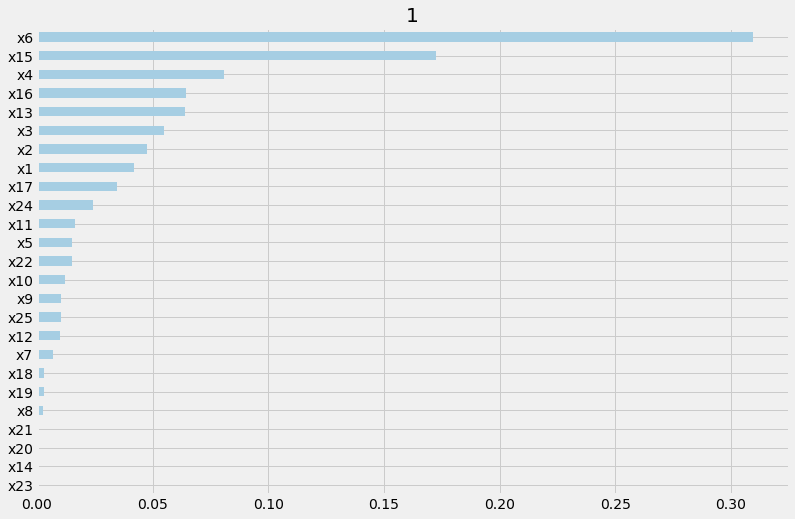

In [172]:
x_learner.plot_importance(X=learner_input_X,
                          tau=ite,
                          model_tau_feature=XGBRegressor(random_state=SEED),
                          features=feature_cols,
                          method='auto',
                          random_state=SEED)

### 特徴量毎のshap値確認

[06:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


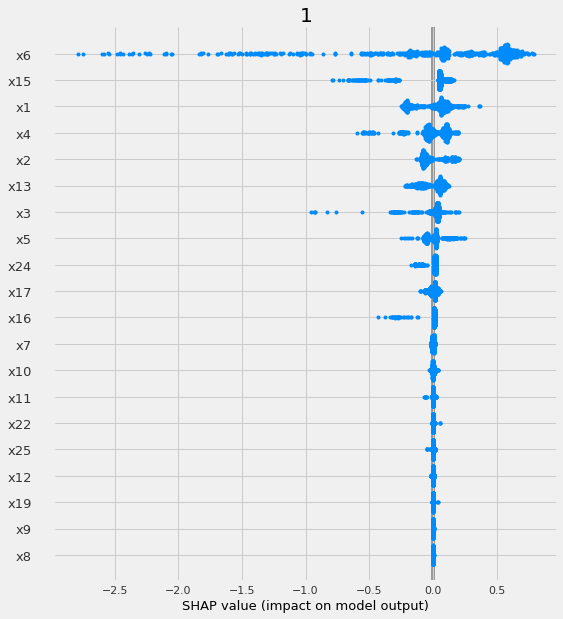

In [191]:
x_learner.plot_shap_values(X=learner_input_X, tau=ite, 
                           features=feature_cols,
                           model_tau_feature=XGBRegressor(random_state=SEED))